# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dill as pickle
from scipy import stats
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 6)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('notebook')



from tqdm import tqdm, tqdm_notebook
import quandl

In [3]:
from utils import *

In [4]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key

# tickers, prices = get_quandl_sharadar(free=True)
# prices = prices.assign(Set='free')

tickers, prices = get_sharadar_train()
prices = prices.query('Set == "train"')

In [5]:
print(len(tickers), 'assets in train set.')
prices

9010 assets in train set.


Open    High    Low  Close      Volume  Dividends  \
Ticker Date                                                             
A      1999-11-18  45.50  50.000  40.00  44.00  44739900.0        0.0   
       1999-11-19  42.94  43.000  39.81  40.38  10897100.0        0.0   
       1999-11-22  41.31  44.000  40.06  44.00   4705200.0        0.0   
...                  ...     ...    ...    ...         ...        ...   
ZYNE   2017-08-16   6.20   7.000   6.04   6.36   1673477.0        0.0   
       2017-08-17   6.36   6.639   6.20   6.32    651837.0        0.0   
       2017-08-18   6.26   6.450   6.17   6.25    423696.0        0.0   

                   Closeunadj Lastupdated    Set  
Ticker Date                                       
A      1999-11-18       44.00  2018-02-11  train  
       1999-11-19       40.38  2018-02-11  train  
       1999-11-22       44.00  2018-02-11  train  
...                       ...         ...    ...  
ZYNE   2017-08-16        6.36  2017-11-01  train  
       2017-08-17        6.32  2017-11-01  train  
       2017-08-18        6.25  2017-11-01  train  

[13355739 rows x 9 columns]

In [6]:
ticker_days = prices.groupby('Ticker')[['Set']].count().rename(columns={'Set': 'n_days'}).reset_index()

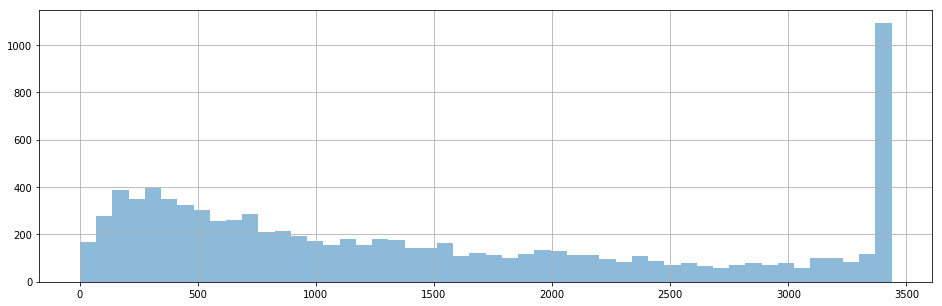

In [7]:
ticker_days.n_days.hist(bins=50, alpha=0.5)

# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

1517 days.


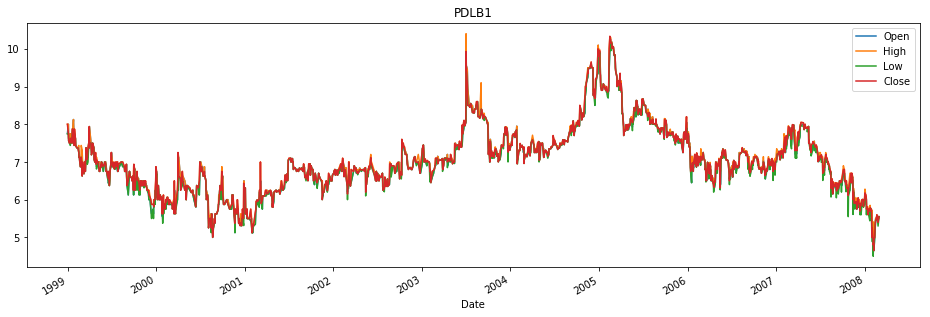

In [63]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [65]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [66]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [67]:
N_ga = 1500
f_ga = gaussian(N_ga, std=30.)
f_ga = f_ga / f_ga.sum()

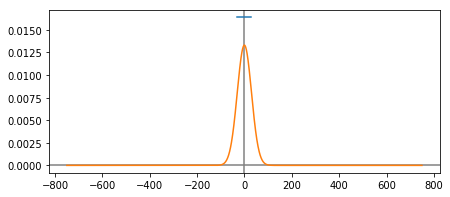

In [68]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Geometric

In [69]:
f_geo = lambda s: np.exp(filters.convolve1d(np.log(price.Close), f_ga))

### Wiener 

In [70]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [71]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

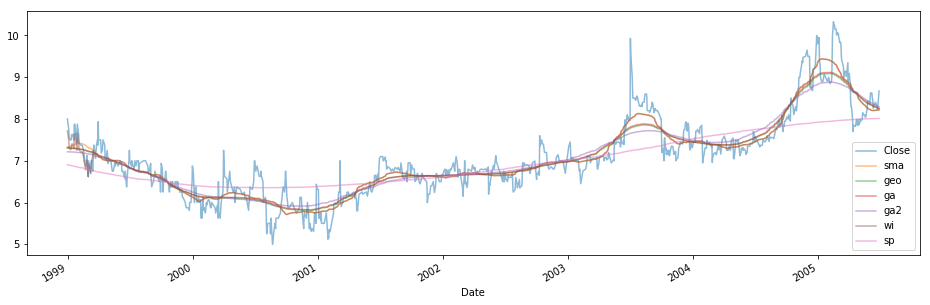

In [72]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(
    sma=filters.convolve1d(price.Close, f_sma),
    geo=f_geo(price.Close),
    ga=filters.convolve1d(price.Close, f_ga),
    ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
    wi=f_wi(price.Close),
    sp=f_sp(price.Close),
)
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

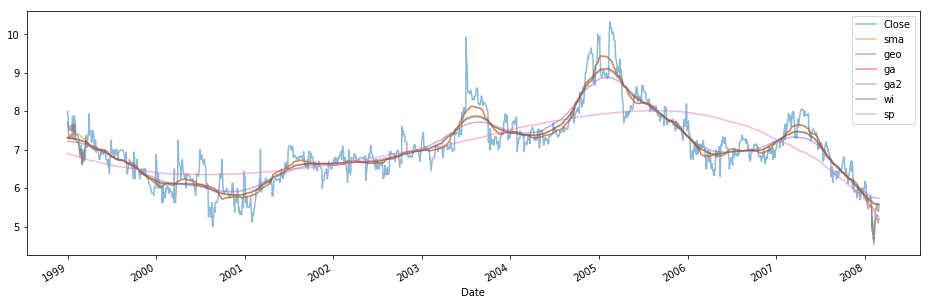

In [73]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [74]:
def smooth_price(df, N=1500, sd=20.):
    f_ga = gaussian(N_ga, std=sd)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [75]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [76]:
results = smooth_price(price)

In [77]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed
Date,,,,,,,,,,
1998-12-31,7.750,8.000,7.750,8.000,12400.0,0.0,8.000,2018-02-11,train,7.406985
1999-01-04,8.000,8.000,7.750,7.750,2100.0,0.0,7.750,2018-02-11,train,7.406099
1999-01-05,7.625,7.625,7.563,7.563,2500.0,0.0,7.563,2018-02-11,train,7.404627
...,...,...,...,...,...,...,...,...,...,...
2008-02-22,5.500,5.500,5.500,5.500,100.0,0.0,5.500,2018-01-24,train,5.445268
2008-02-25,5.450,5.450,5.300,5.400,15200.0,0.0,5.400,2018-01-24,train,5.444105
2008-02-29,5.550,5.550,5.550,5.550,1100.0,0.0,5.550,2018-01-24,train,5.443717


In [78]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [79]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [80]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [81]:
peaks

array([ 213,  389,  473,  662,  737,  924, 1228, 1340])

In [82]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [83]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown
Date,,,,,,,,,,,,
1998-12-31,7.750,8.000,7.750,8.000,12400.0,0.0,8.000,2018-02-11,train,7.406985,-1.0,NaN
1999-01-04,8.000,8.000,7.750,7.750,2100.0,0.0,7.750,2018-02-11,train,7.406099,-1.0,NaN
1999-01-05,7.625,7.625,7.563,7.563,2500.0,0.0,7.563,2018-02-11,train,7.404627,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-02-22,5.500,5.500,5.500,5.500,100.0,0.0,5.500,2018-01-24,train,5.445268,-1.0,NaN
2008-02-25,5.450,5.450,5.300,5.400,15200.0,0.0,5.400,2018-01-24,train,5.444105,-1.0,NaN
2008-02-29,5.550,5.550,5.550,5.550,1100.0,0.0,5.550,2018-01-24,train,5.443717,-1.0,NaN


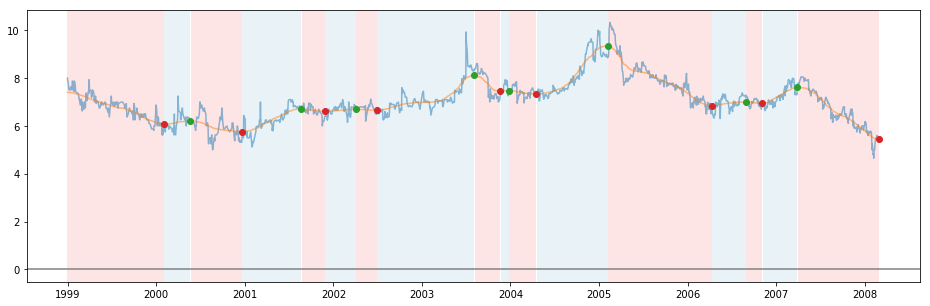

In [84]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [85]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

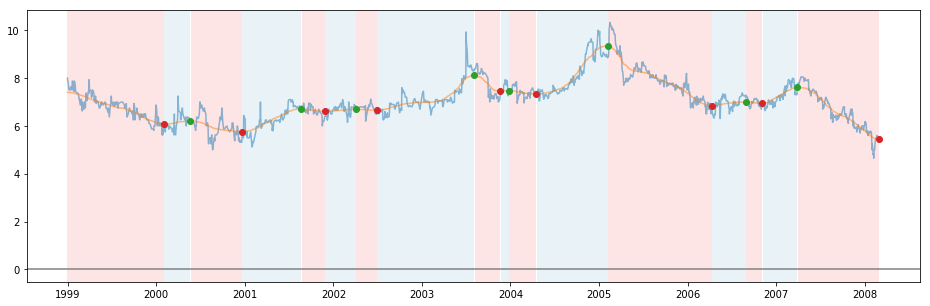

In [86]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [87]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

array([[0.58206987, 0.        ],
       [0.        , 0.41793013]])

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [35]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

Breakpoints: [  0 101 153 209 255 333]


In [36]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,,
2006-01-23,14.57,14.74,14.494,14.65,31401.0,0.0,14.65,2017-11-01,train,15.115405,1.0,NaN,1.0
2006-01-24,14.65,14.66,14.580,14.63,92631.0,0.0,14.63,2017-11-01,train,15.118084,1.0,NaN,1.0
2006-01-25,13.65,14.03,13.250,14.03,326274.0,0.0,14.03,2017-11-01,train,15.123432,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-04-07,16.45,16.56,16.190,16.27,99903.0,0.0,16.27,2017-11-01,train,16.555327,1.0,NaN,1.0
2006-04-10,16.24,16.51,15.900,16.05,296983.0,0.0,16.05,2017-11-01,train,16.557154,1.0,NaN,1.0
2006-04-11,16.10,16.25,15.820,16.00,143049.0,0.0,16.00,2017-11-01,train,16.557398,1.0,NaN,1.0


In [37]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [38]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,,
2005-06-14,12.50,12.60,12.25,12.50,3176366.0,0.0,12.50,2017-11-01,train,13.971432,1.0,0.077326,1.0
2005-06-15,12.50,13.19,12.50,12.85,706831.0,0.0,12.85,2017-11-01,train,13.973910,1.0,0.077326,1.0
2005-06-16,12.95,13.10,12.70,13.02,473600.0,0.0,13.02,2017-11-01,train,13.978023,1.0,0.077326,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-10-04,18.85,19.12,18.85,19.10,502672.0,0.0,19.10,2017-11-01,train,17.938580,1.0,0.187750,1.0
2006-10-05,19.02,19.19,19.02,19.07,221688.0,0.0,19.07,2017-11-01,train,17.943993,1.0,0.187750,1.0
2006-10-06,18.97,19.09,18.89,18.91,339546.0,0.0,18.91,2017-11-01,train,17.945801,1.0,0.187750,1.0


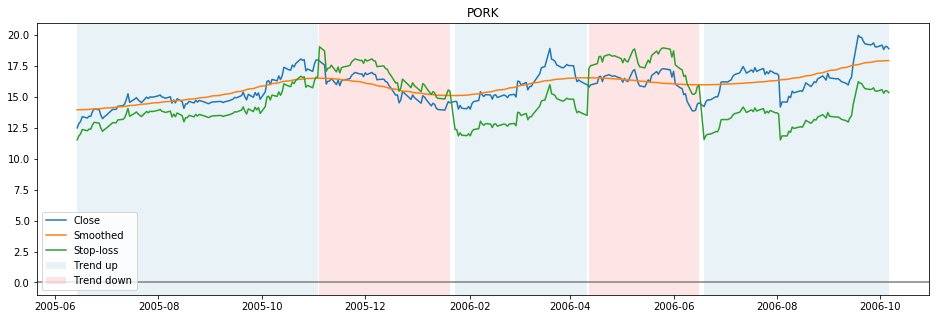

In [41]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0,
                facecolor=pal[0], alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0,
                facecolor=pal[4], alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Smoothed, label='Smoothed')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

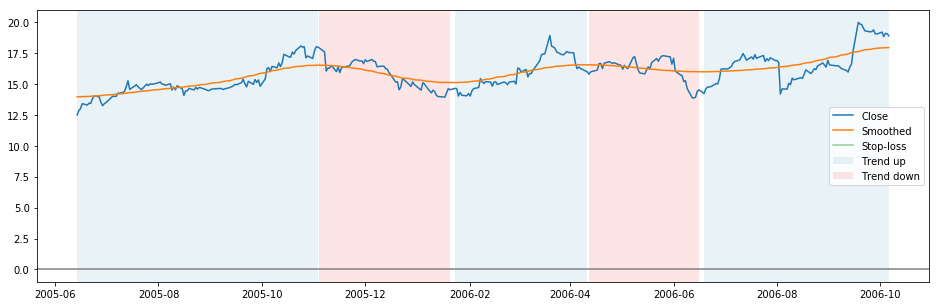

In [42]:
res2 = find_trends(price)
plot_trends(res2)

## Filters and lags

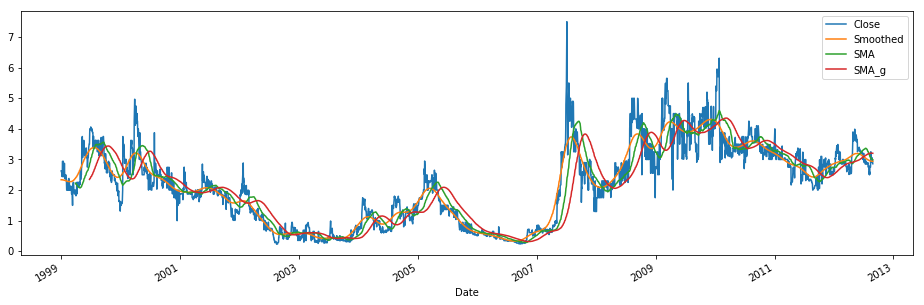

In [125]:
results = smooth_price(price, sd=30)
results = results.assign(SMA=results.Close.rolling(60).mean())
results = results.assign(SMA_g=results.Close.rolling(120, win_type='gaussian').mean(std=30))
# results = results.assign(SMA=results.SMA.shift(-30))
results[['Close', 'Smoothed', 'SMA', 'SMA_g']].plot()

In [108]:
res_0 = smooth_price(price, sd=30)
res_lag = price.assign(Smoothed=results.Close.rolling(60).mean())

In [112]:
trends_0 = find_trends(price, sd=30)
trends_lag = find_trends(res_lag, True)

/Users/juanpabloacosta/GitHub/trend-following/utils.py:365: RuntimeWarning: invalid value encountered in log
  icagr = np.log(ratio) * (364.25 / (close_b.index[-1] - close_b.index[0]).components.days)


In [113]:
confusion_matrix(trends_0.Trend.values, trends_lag.Trend.values) / len(trends_0)

array([[0.39656677, 0.16118708],
       [0.15304044, 0.2892057 ]])

In [127]:
confusion_matrix(trends_0.Trend.values,
                 trends_lag.Trend.shift(-30).fillna(method='ffill').values) / len(trends_0)

array([[0.47948793, 0.07826593],
       [0.07011929, 0.37212685]])

In [129]:
confusion_matrix(trends_0.Trend.values,
                 trends_0.Trend.shift(30).fillna(method='bfill').values) / len(trends_0)

array([[0.43148094, 0.12627291],
       [0.12627291, 0.31597323]])

# Sample...

## A single asset 

In [8]:
from utils import *

In [9]:
ticker = np.random.choice(tickers)
# ticker = 'TFCO'
price = prices.loc[ticker]
print(len(price), 'days.')

3437 days.


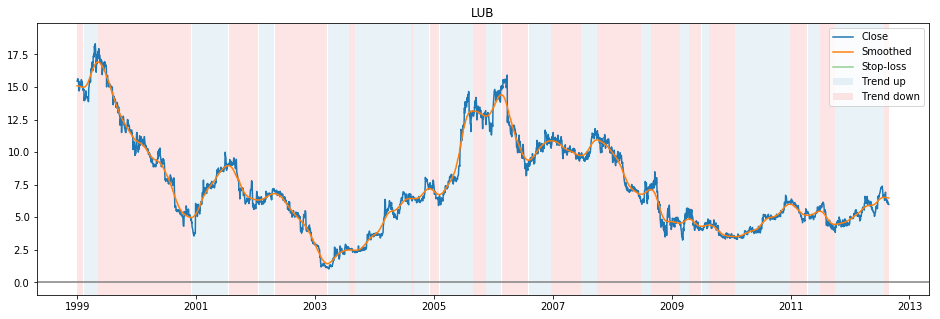

In [10]:
trends = find_trends(price, sd=20.)
plot_trends(trends, ticker)

In [11]:
trends

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,n_Trend,Max_Drawdown,Ratio,ICAGR,Bliss,Trend_Start,Trend_End
Date,,,,,,,,,,,,,,,,,,
1998-12-31,15.38,15.750,15.19,15.44,73300.0,0.0,15.44,2018-02-11,train,15.084942,-1.0,1.0,0.053737,1.036269,0.360478,6.708201,1998-12-31,1999-02-05
1999-01-04,15.19,15.750,15.19,15.63,49700.0,0.0,15.63,2018-02-11,train,15.083782,-1.0,1.0,NaN,NaN,NaN,NaN,1998-12-31,1999-02-05
1999-01-05,15.81,16.000,15.50,15.56,28200.0,0.0,15.56,2018-02-11,train,15.081862,-1.0,1.0,NaN,NaN,NaN,NaN,1998-12-31,1999-02-05
1999-01-06,15.63,15.630,15.13,15.56,47100.0,0.0,15.56,2018-02-11,train,15.079205,-1.0,1.0,NaN,NaN,NaN,NaN,1998-12-31,1999-02-05
1999-01-07,15.50,15.630,15.38,15.50,51000.0,0.0,15.50,2018-02-11,train,15.075838,-1.0,1.0,NaN,NaN,NaN,NaN,1998-12-31,1999-02-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-21,6.21,6.269,6.10,6.14,29200.0,0.0,6.14,2017-11-01,train,6.487630,-1.0,33.0,NaN,NaN,NaN,NaN,2012-07-30,2012-08-27
2012-08-22,6.13,6.330,6.12,6.14,9000.0,0.0,6.14,2017-11-01,train,6.486085,-1.0,33.0,NaN,NaN,NaN,NaN,2012-07-30,2012-08-27
2012-08-23,6.11,6.130,6.00,6.00,54400.0,0.0,6.00,2017-11-01,train,6.484963,-1.0,33.0,NaN,NaN,NaN,NaN,2012-07-30,2012-08-27


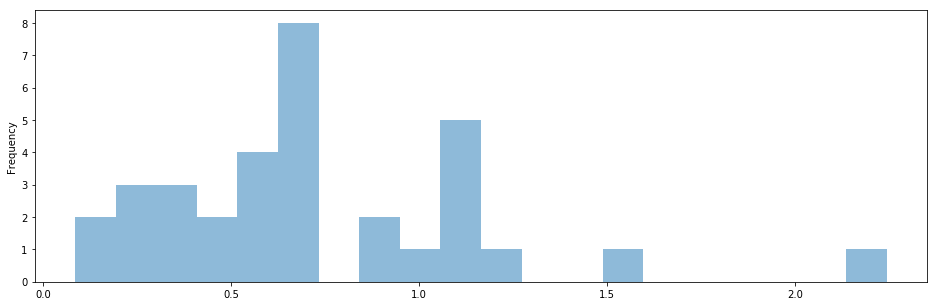

In [16]:
trends.groupby('n_Trend').first().ICAGR.plot.hist(bins=20, alpha=0.5)

In [ ]:
trends.groupby('n_Trend').Trend.count()

In [ ]:
summarise_trends(price, sd=20)

In [ ]:
trends2 = find_trends(price, sd=5.)
plot_trends(trends2, ticker)

In [ ]:
summarise_trends(price, sd=5)

In [ ]:
sds = np.arange(5, 250, step=5)
sum_trends = pd.concat([summarise_trends(price, s) for s in sds], axis=0)

In [ ]:
sum_trends

In [ ]:
sum_trends.set_index('sd')[['mean', 'min', '50%', 'max']].plot();

In [ ]:
sum_trends.set_index('sd')[['trend_freq']].plot();

In [ ]:
sum_trends.set_index('sd')[['ICAGR', 'mean_ICAGR', 'neg_ICAGR']].plot();

In [ ]:
sum_trends.set_index('sd')[['Bliss']].plot();

## Multiple assets

### Single thread

In [ ]:
from utils import *
# summarise_trends(prices.loc['A'], sd=100)
# results = pickle.load(open('output/Finding the trends - sd values for filtering.pickle', 'rb'))

In [ ]:
# n_tickers = 1000
sds = np.arange(5, 300, step=5)

results = []
# grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
grouped = prices.groupby('Ticker')
# grouped = prices.loc[list(set(results_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    res_g = []
    for s in tqdm_notebook(sds, desc='sd:', leave=False, postfix=dict(n_days=str(len(group)))):
        try:
            res_g.append(summarise_trends(group.reset_index('Ticker'), s))
        except:
            pass
    try:
        results.append(pd.concat(res_g, axis=0).assign(Ticker=name))
    except:
        pass

In [ ]:
# pickle.dump(results, open('output/Finding the trends - std values for filtering.pickle', 'wb'))

### Results

In [ ]:
results = pickle.load(open('output/Finding the trends - std values for filtering.pickle', 'rb'))

In [ ]:
results_df = pd.concat(results, axis=0, sort=True)
# results_df = results_df.query('n_days > 3 * sd')
results_df = results_df.set_index('Ticker').loc[np.random.choice(results_df.Ticker.values, size=500)]
results_df = results_df.reset_index().query('n_days > 3 * sd')
results_df

####  ICAGR

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.25).encode(
    x='sd',
    y='ICAGR',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd']
).properties(width=800, height=300).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(ICAGR)'
)
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(ICAGR)', axis=alt.Axis(title='ICAGR')),
    y2='ci1(ICAGR)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(ICAGR)', axis=alt.Axis(title='ICAGR')),
    y2='max(ICAGR)',
).properties(width=800, height=300).interactive()
total_interval + confidence_interval + line

#### Max Drawdown

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.25).encode(
    x='sd',
    y='Max_Drawdown',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd']
).properties(width=800, height=300).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(Max_Drawdown)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(Max_Drawdown)', axis=alt.Axis(title='Max_Drawdown')),
    y2='ci1(Max_Drawdown)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(Max_Drawdown)', axis=alt.Axis(title='Max_Drawdown')),
    y2='max(Max_Drawdown)',
)
# total_interval + 
confidence_interval + line

#### Bliss

In [ ]:
alt.Chart(results_df.reset_index()).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y='Bliss',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=300
).interactive()

In [ ]:
line = alt.Chart(results_df.reset_index()).mark_line().encode(
    x='sd',
    y='mean(Bliss)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(Bliss)', axis=alt.Axis(title='Bliss')),
    y2='ci1(Bliss)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(Bliss)', axis=alt.Axis(title='Bliss')),
    y2='max(Bliss)',
)
# total_interval + 
confidence_interval + line

#### Error frequency

In [ ]:
line = alt.Chart(results_df.reset_index(), title='Number of negative ratios / number of trends').mark_line().encode(
    x='sd',
    y='mean(neg_freq)'
).properties(width=800, height=300).interactive()
confidence_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.5).encode(
    x='sd',
    y=alt.Y('ci0(neg_freq)', axis=alt.Axis(title='neg_freq')),
    y2='ci1(neg_freq)',
)
total_interval = alt.Chart(results_df.reset_index()).mark_area(opacity=0.1).encode(
    x='sd',
    y=alt.Y('min(neg_freq)', axis=alt.Axis(title='neg_freq')),
    y2='max(neg_freq)',
)
# total_interval + 
confidence_interval + line

In [ ]:
alt.Chart(results_df.assign(Color = results_df.neg_ICAGR > 0).reset_index()).mark_area(opacity=0.25).encode(
    x='sd',
    y=alt.Y('count()'),
    color=alt.Color('Color', title='neg_ICAGR'),
#     size='sd',
#     tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd', 'ICAGR', 'neg_ICAGR']
).properties(
    width=800,
    height=200
).interactive()

In [ ]:
alt.Chart(results_df.assign(neg_ICAGR = results_df.neg_ICAGR.astype(str)).reset_index()).mark_area(opacity=0.25).encode(
    x='sd',
    y=alt.Y('count()'),
    color=alt.Color('neg_ICAGR', title='neg_ICAGR',
                    scale=alt.Scale(domain=[str(i) for i in np.arange(11)])),
#     size='sd',
#     tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days', 'sd', 'ICAGR', 'neg_ICAGR']
).properties(
    width=800,
    height=200
).interactive()

#### Trend frequency and duration

In [ ]:
alt.Chart(results_df).mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('trend_freq', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

In [ ]:
alt.Chart(results_df, title='Trend duration (days)').mark_line(point=True, opacity=0.5).encode(
    x='sd',
    y=alt.Y('mean', scale=alt.Scale(type='log')), #y='trend_freq',
    color=alt.Color('Ticker', legend=None),
    size='n_days',
    tooltip=['Ticker', 'max', 'min', '50%', 'mean', 'count', 'n_days']
).properties(
    width=800,
    height=200
).interactive()

## Lab

### Ideal System (that cheats...)

In [8]:
from trading_strategies import *
from utils import *

In [29]:
# ticker = np.random.choice(results_df.Ticker)  
ticker = np.random.choice(tickers)
# ticker = 'NCMV'
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

MAG1 2928 days.


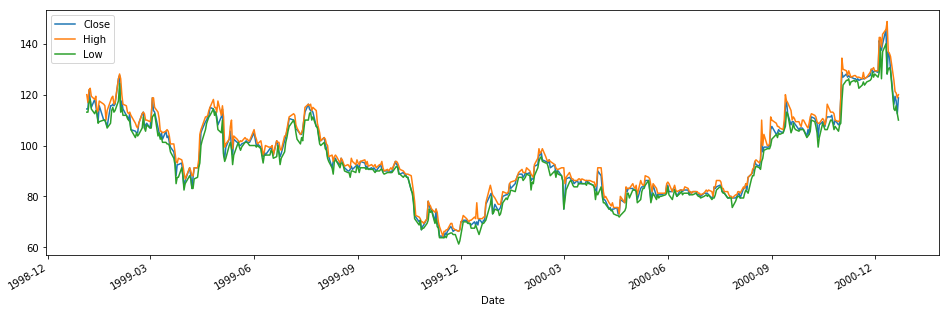

In [35]:
price[['Close', 'High', 'Low']][:500].plot()

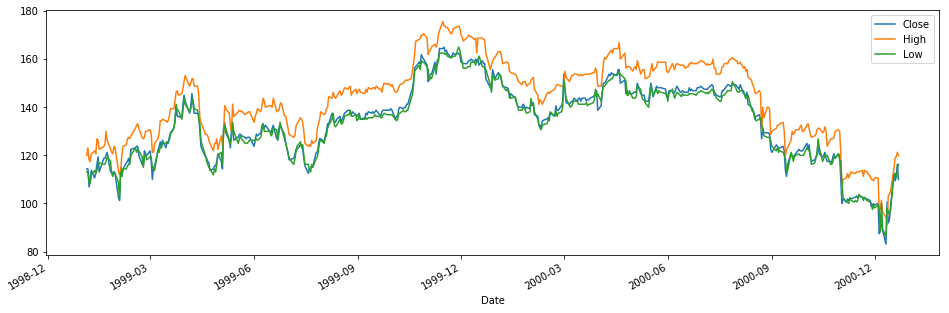

In [40]:
price_b = price[['Close', 'High', 'Low']][:500]
price_b.transform(lambda x: x[0] - 1 * (x - x[0])).plot()

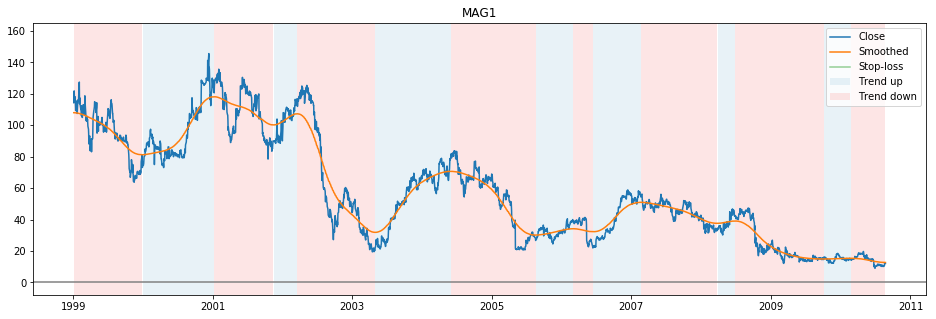

In [30]:
trends = find_trends(price, sd=50)
plot_trends(trends, ticker)

In [11]:
trends.groupby('n_Trend').first().iloc[5:].head(6)

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End
n_Trend,,,,,,,,,,,,,,,,,,,,
6.0,0.037,0.037,0.032,0.032,17004.0,0.0,0.032,2018-01-12,train,0.033874,1.0,0.250000,0.077070,0.600000,0.0,1.187500,0.175833,0.703331,2005-10-28,2006-10-19
7.0,0.038,0.038,0.038,0.038,1040.0,0.0,0.038,2018-01-12,train,0.035642,-1.0,0.217391,0.071040,0.384615,0.0,1.184211,0.219950,1.011771,2006-10-20,2007-07-27
8.0,0.031,0.031,0.031,0.031,3970.0,0.0,0.031,2018-01-12,train,0.034099,1.0,0.432432,0.036823,0.523810,0.0,1.225806,0.421369,0.974415,2007-07-30,2008-01-22


In [21]:
cheat_ts = Oracle_Trading_Strategy(price, equity=1e6, name=ticker, #heat=0.63,
                                   trend=trends.Trend.values,
                                   max_dd= trends.max_TR.fillna(method='ffill').values + \
                                           trends.Max_Drawdown.fillna(method='ffill').values)
cheat_ts.excecute(warmup=1)

In [22]:
cheat_ts.performance

{'Years': 9.07343857240906,
 'Ratio': 4.210464371749999,
 'ICAGR': 0.15843750219032587,
 'Max_Drawdown': 0.5970873290312311,
 'Bliss': 0.2653506354713461,
 'Lake_Ratio': 0.7754331887612312,
 'Sea_Ratio': 1.0733380029903352}

In [23]:
trades_profit = cheat_ts.get_trades_profit()
trades_profit.head(3)

,transaction,Entry Date,Entry Price,Amount,transaction,Exit Date,Exit Price,PL,PL_pct
0,0,1999-01-11,4.3755,-21915.0,1,1999-02-17,6.4375,-45188.730,-0.471260
1,2,1999-02-18,4.4530,-19586.0,3,1999-05-12,3.4375,19889.583,0.228049
2,4,1999-05-14,2.7190,-35444.0,5,1999-06-03,2.4375,9977.486,0.103531


In [24]:
cheat_ts.get_trades_profit().tail(6)

,transaction,Entry Date,Entry Price,Amount,transaction,Exit Date,Exit Price,PL,PL_pct
41,82,2004-10-04,0.0215,-4.826675e+06,83,2004-10-14,0.0325,-53093.421186,-0.511628
42,84,2004-10-29,0.0290,-4.595834e+06,85,2004-12-16,0.0575,-130981.260201,-0.982759
43,86,2004-12-22,0.0360,-4.159229e+06,87,2005-10-31,0.0345,6238.844220,0.041667
44,88,2005-11-15,0.0340,4.174827e+06,89,2006-11-15,0.0335,-2087.413296,-0.014706
45,90,2006-12-04,0.0310,-4.168093e+06,91,2007-08-01,0.0320,-4168.093000,-0.032258
46,92,2007-08-06,0.0340,4.156828e+06,93,2008-01-22,0.0380,16627.311535,0.117647


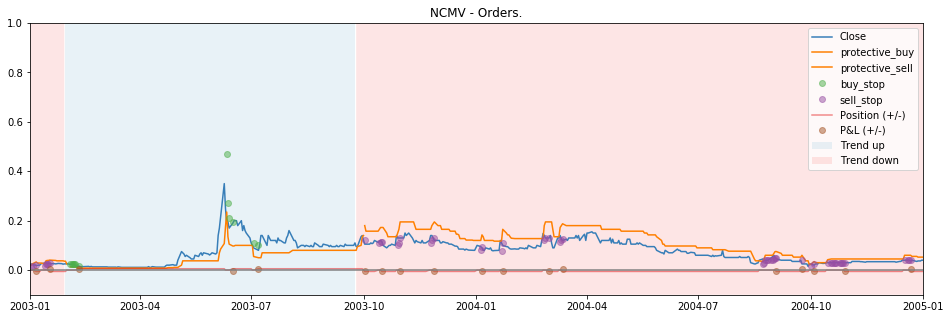

In [25]:
cheat_ts.plot_orders()
plt.xlim((datetime(2003, 1, 1), datetime(2005, 1, 1)));
plt.ylim((-0.1, 1));

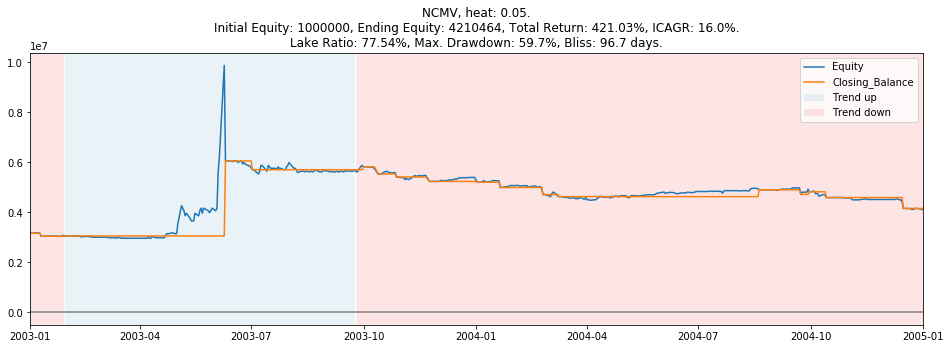

In [28]:
cheat_ts.plot_equity()
plt.xlim((datetime(2003, 1, 1), datetime(2005, 1, 1)));
# plt.ylim((-10, 50));

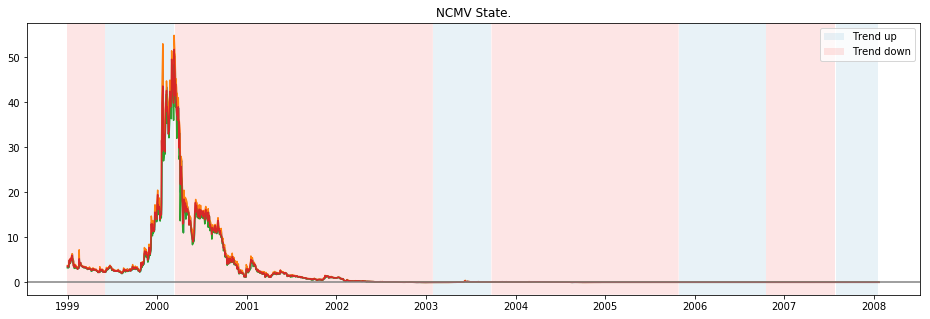

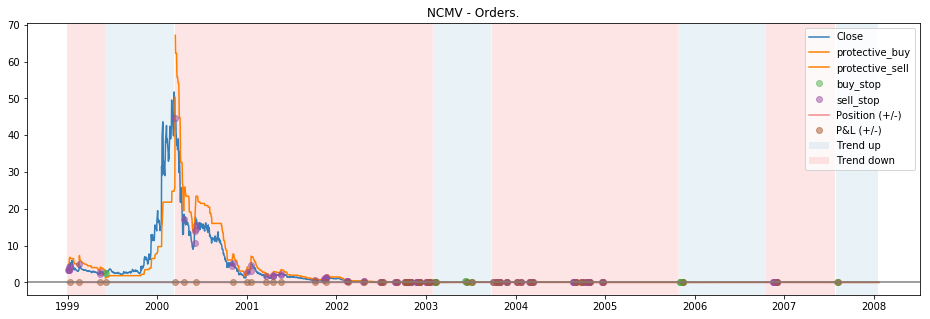

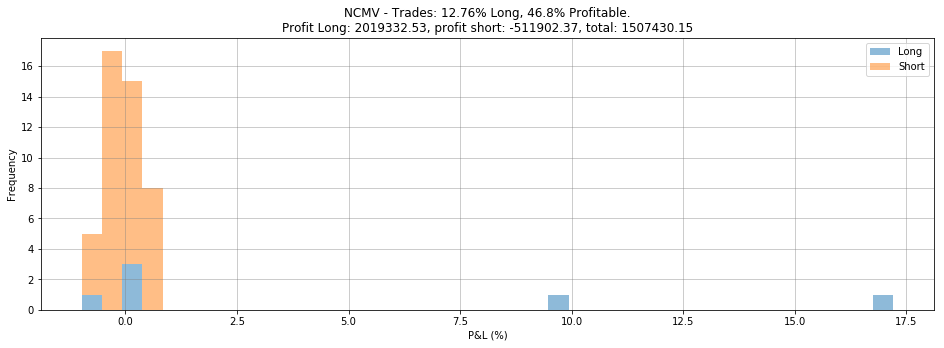

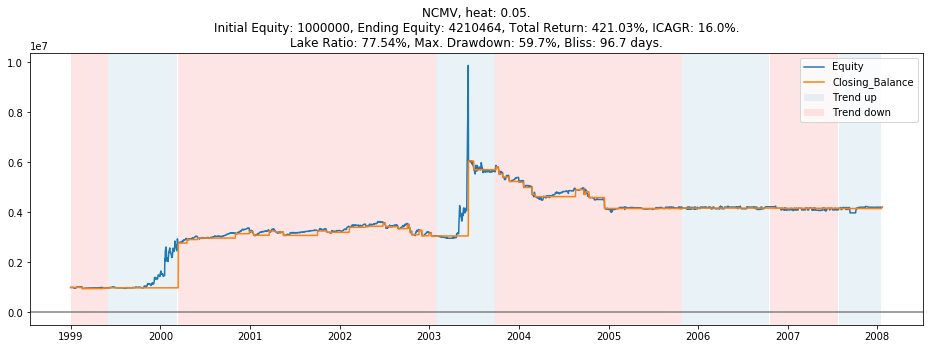

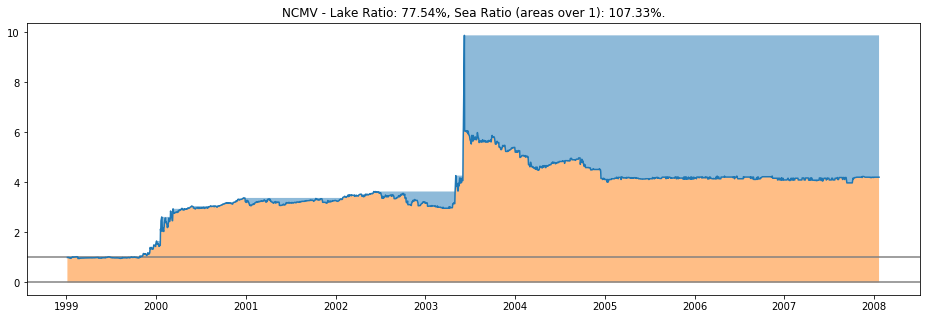

In [27]:
cheat_ts.plot_state()
cheat_ts.plot_orders()
cheat_ts.plot_trades()
cheat_ts.plot_equity()
cheat_ts.plot_lake_ratio()

### Lag vs sd

In [33]:
from trading_strategies import *
from utils import *
from joblib import Parallel, delayed

In [34]:
def get_performance(sd, lag=0, heat=0.05):
    
    tr = find_trends(price, sd)
    trend = tr.Trend.shift(lag).fillna(value=0)
    
    ch_ts = Oracle_Trading_Strategy(price, equity=1e6, name=ticker, 
                                    heat=heat,
                                    trend=trend,
                                    max_dd=tr.ATR.fillna(method='ffill').values + \
                                           tr.Max_Drawdown.fillna(method='ffill').values)
    ch_ts.excecute(warmup=1)
    
    return {'sd': sd, 'lag':lag, 'heat': heat, **ch_ts.performance}

In [35]:
lags = np.concatenate((np.arange(0, 20, 5), np.arange(20, 41, 5)))
sds = np.concatenate((np.arange(5, 40, 2.5), np.arange(40, 81, 5)))
heats = np.arange(0.025, 0.81, step=0.025)

print('Lags: ', len(lags), ', sds: ', len(sds), ', heats: ', len(heats),
      '.\nSteps: ', len(lags) * len(sds) * len(heats), sep='')
print('')
print('lags:', lags)
print('sds:', sds)
print('heats:', heats)

Lags: 9, sds: 23, heats: 32.
Steps: 6624

lags: [ 0  5 10 15 20 25 30 35 40]
sds: [ 5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30.  32.5 35.  37.5
 40.  45.  50.  55.  60.  65.  70.  75.  80. ]
heats: [0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6
 0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8  ]


In [36]:
perf = Parallel(-1, verbose=10)(
    delayed(get_performance)(s, l, h)
    for s, l, h in itertools.product(sds, lags, heats))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

In [37]:
perf_df = pd.concat([DataFrame(Series(p)).transpose() for p in perf], axis=0)
perf_df = perf_df.assign(
    heat = np.round(perf_df.heat.values, 2),
    sd = np.round(perf_df.sd.values, 1),
    ICAGR = np.clip(perf_df.ICAGR.values, -20, None),
    Bliss = np.clip(perf_df.Bliss.values, -20, None),
)
perf_df

,sd,lag,heat,Years,Ratio,ICAGR,Max_Drawdown,Bliss,Lake_Ratio,Sea_Ratio
0,5.0,0.0,0.02,9.073439,5.449203,0.186861,0.490613,0.380872,0.367862,0.463783
0,5.0,0.0,0.05,9.073439,18.883590,0.323835,0.664450,0.487372,0.592800,0.626390
0,5.0,0.0,0.08,9.073439,51.237476,0.433846,0.768605,0.564458,0.731530,0.743670
...,...,...,...,...,...,...,...,...,...,...
0,80.0,40.0,0.75,1.990391,-0.001946,-20.000000,1.000093,-20.000000,33.317427,-39.447889
0,80.0,40.0,0.78,1.276596,-0.008226,-20.000000,1.004257,-20.000000,34.065959,-41.182482
0,80.0,40.0,0.80,1.276596,-0.276151,-20.000000,1.016414,-20.000000,58.772140,-29.064022


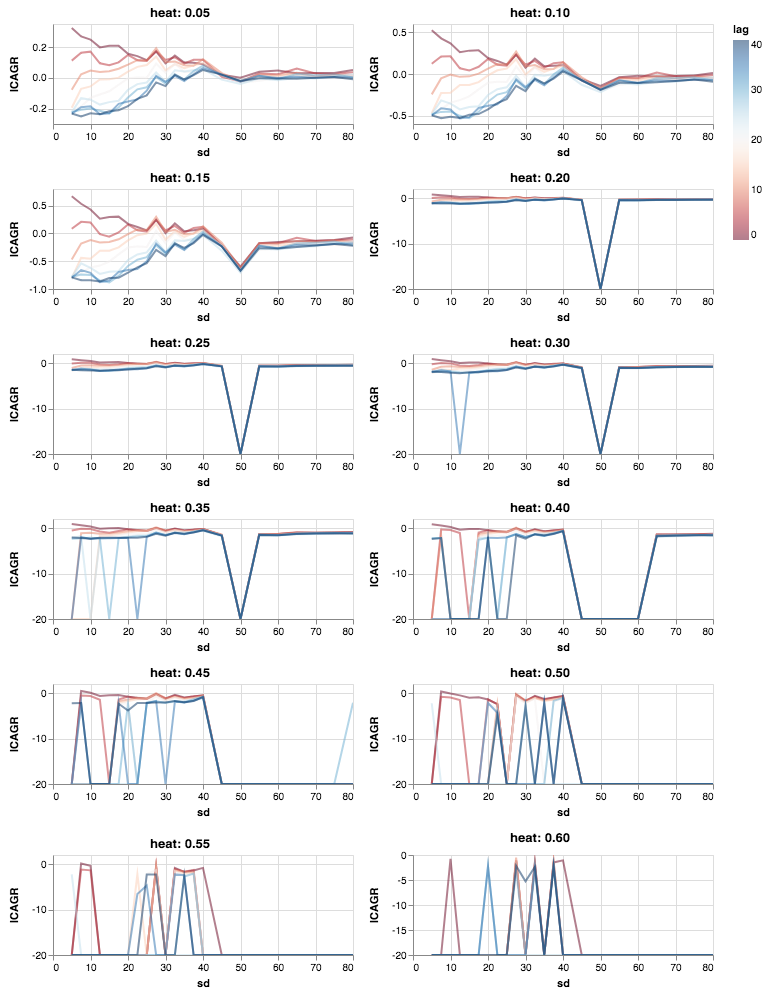

In [140]:
from altair.expr import datum
base = alt.Chart(
    perf_df,
    title=ticker,
    
).mark_line(
    opacity=0.5,
    point=False
).encode(
    x='sd',
    y='ICAGR',
    color=alt.Color('lag', scale=alt.Scale(scheme='redblue')),
    tooltip=['sd', 'lag', 'ICAGR', 'Bliss']
).properties(width=300, height=100).interactive()

alt.vconcat(
    base.properties(title='heat: 0.05').transform_filter(datum.heat==0.05) |
    base.properties(title='heat: 0.10').transform_filter(datum.heat==0.10),
    base.properties(title='heat: 0.15').transform_filter(datum.heat==0.15) |
    base.properties(title='heat: 0.20').transform_filter(datum.heat==0.20),
    base.properties(title='heat: 0.25').transform_filter(datum.heat==0.25) |
    base.properties(title='heat: 0.30').transform_filter(datum.heat==0.30),
    base.properties(title='heat: 0.35').transform_filter(datum.heat==0.35) |
    base.properties(title='heat: 0.40').transform_filter(datum.heat==0.40),
    base.properties(title='heat: 0.45').transform_filter(datum.heat==0.45) |
    base.properties(title='heat: 0.50').transform_filter(datum.heat==0.50),
    base.properties(title='heat: 0.55').transform_filter(datum.heat==0.55) |
    base.properties(title='heat: 0.60').transform_filter(datum.heat==0.60),
)

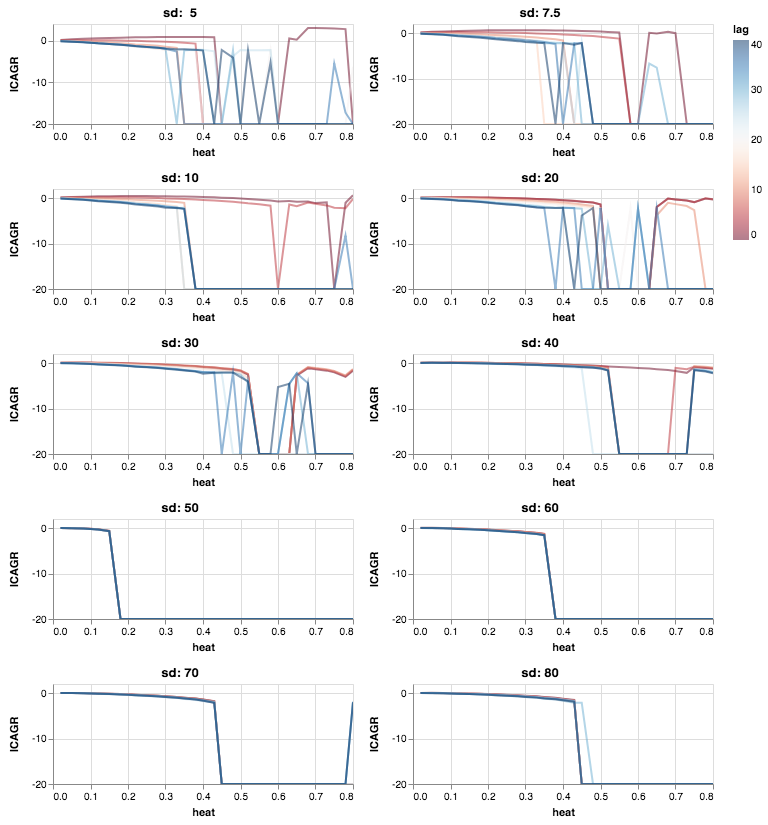

In [173]:
from altair.expr import datum
base = alt.Chart(
    perf_df,
    title=ticker
).mark_line(
    opacity=0.5,
    point=False
).encode(
    x='heat',
    y='ICAGR',
    color=alt.Color('lag', scale=alt.Scale(scheme='redblue')),
    tooltip=['heat', 'sd', 'lag', 'ICAGR', 'Bliss']
).properties(width=300, height=100).interactive()

alt.vconcat(
    base.properties(title='sd:  5').transform_filter(datum.sd==5) |
    base.properties(title='sd: 7.5').transform_filter(datum.sd==7.5),
    base.properties(title='sd: 10').transform_filter(datum.sd==10) |
    base.properties(title='sd: 20').transform_filter(datum.sd==20),
    base.properties(title='sd: 30').transform_filter(datum.sd==30) |
    base.properties(title='sd: 40').transform_filter(datum.sd==40),
    base.properties(title='sd: 50').transform_filter(datum.sd==50) |
    base.properties(title='sd: 60').transform_filter(datum.sd==60),
    base.properties(title='sd: 70').transform_filter(datum.sd==70) |
    base.properties(title='sd: 80').transform_filter(datum.sd==80),
)

## Trades distribution

In [739]:
n_tickers = 100

trades = []
grouped = prices.loc[np.random.choice(tickers, size=n_tickers)].groupby('Ticker')
# grouped = prices.groupby('Ticker')
# grouped = prices.loc[list(set(trades_df.Ticker.values))].groupby('Ticker')

for name, group in tqdm_notebook(grouped, desc='Ticker:'):
    
    tr = find_trends(group.reset_index('Ticker'), 35)
    trend = tr.Trend.shift(20).fillna(value=0)
    
    cheat_ts = Oracle_Trading_Strategy(
                   group.reset_index('Ticker'),
                   equity=1e6, name=name,
                   trend=tr.Trend.values,
                   max_dd=tr.Max_Drawdown.fillna(method='ffill').values + \
                          tr.Max_Drawdown.fillna(method='ffill').values,
    )
    cheat_ts.excecute(warmup=1)
    try:
        trades.append(cheat_ts.get_trades_profit().assign(Ticker=name))
    except:
        pass

/Users/juanpabloacosta/GitHub/trend-following/trading_strategies.py:339: RuntimeWarning: divide by zero encountered in log
  # Instantaneously Compounding Annual Gain
/Users/juanpabloacosta/GitHub/trend-following/utils.py:341: RuntimeWarning: divide by zero encountered in double_scalars
  drawdown = low / peak - 1


In [740]:
trades_df = pd.concat(trades, axis=0)
DataFrame(trades_df.PL_pct.agg(['min', 'max', 'mean', 'std',
                                'skew', 'kurtosis', 'count'])).transpose()

,min,max,mean,std,skew,kurtosis,count
PL_pct,-12.333333,41.349796,0.286219,1.494189,16.216502,393.709722,1716.0


In [741]:
trades_df.sort_values('PL_pct')

,transaction,Entry Date,Entry Price,Amount,transaction,Exit Date,Exit Price,PL,PL_pct,Ticker
6,12,2014-08-21,0.0600,-1406557.165,13.0,2014-10-01,0.800,-1.040852e+06,-12.333333,HADV
12,24,2016-06-07,0.0600,-57479.000,25.0,2016-09-27,0.205,-8.334455e+03,-2.416667,USBL
4,8,2014-09-19,0.1210,-244404.000,9.0,2014-11-06,0.365,-5.963458e+04,-2.016529,USBL
...,...,...,...,...,...,...,...,...,...,...
1,2,2000-03-24,11.3125,NaN,3.0,2004-09-02,8.855,NaN,NaN,JJZ
0,0,1999-01-05,NaN,4354.000,1.0,1999-06-02,31.469,NaN,NaN,VRX1
1,2,1999-06-07,32.2815,NaN,3.0,2007-03-22,17.865,NaN,NaN,VRX1


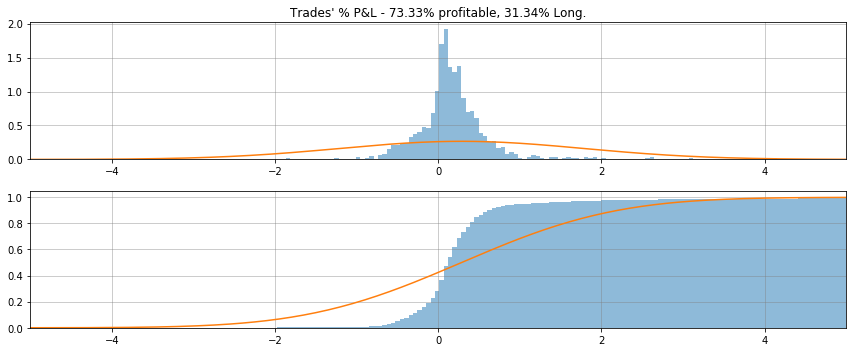

In [742]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

tit = "Trades' % P&L - " + str(int(10000 * (trades_df.PL > 0).mean())/100) + '% profitable, '
tit += str(int(10000 * (trades_df.Amount > 0).mean())/100) + '% Long.'
plt.subplot(211)
plt.title(tit)
trades_df.PL_pct.hist(cumulative=False, density=1, bins=1000, alpha=0.5)
plt.plot(np.arange(-10, 10, 0.05), stats.norm.pdf(np.arange(-10, 10, 0.05),
                                                  loc=trades_df.PL_pct.mean(),
                                                  scale=trades_df.PL_pct.std()))
plt.grid(c='grey', alpha=0.5)
plt.xlim((-5, 5))

plt.subplot(212)
trades_df.PL_pct.hist(cumulative=True, density=1, bins=1000, alpha=0.5)
plt.plot(np.arange(-10, 10, 0.05), stats.norm.cdf(np.arange(-10, 10, 0.05),
                                                  loc=trades_df.PL_pct.mean(),
                                                  scale=trades_df.PL_pct.std()))
plt.grid(c='grey', alpha=0.5)
plt.xlim((-5, 5))
plt.tight_layout()
plt.show()

# Data transforms for learning

In [ ]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(ticker, len(price), 'days.')

In [ ]:
df = price
tr = find_trends(df)
tr = tr[['Open', 'High', 'Low', 'Close', 'Volume', 'Set', 'Trend', 'Max_Drawdown', 'ATR', 'ICAGR']]
tr = tr.assign(Ch = tr.Close.pct_change().add(1).apply('log'))
tr = tr.assign(Ch2 = tr.Ch.pow(2), Ch3 = tr.Ch.pow(3), Ch4 = tr.Ch.pow(4))

In [ ]:
tr

In [ ]:
def transform_trends(df, sd=15):
    tr = find_trends(df, sd)
    tr = tr.loc

# TO DO:

1. Better estimation of stop_loss_pct.  Sometimes, the trend period's max_drawdown of the Close is too small.  Include High and Low in the calculation.  (c.f. ATR)
1. Determine the equivalence between SMA and lagged gaussian filter (which lag?).
1. Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
1. Exit by volume (~extreme reduction, bankrupt, ...).
1. Feature engineering.
  * c.f. fast.ai's `add_datepart` function.
